In [1]:
import os
import torch

# Setting up the environment to use only GPU 2
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check number of GPUs
print(f"Number of GPUs: {torch.cuda.device_count()}")

# Check GPU name
print(f"GPU name: {torch.cuda.get_device_name()}")

# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
Number of GPUs: 1
GPU name: NVIDIA A100-SXM4-40GB
PyTorch version: 2.4.1+cu121


In [2]:
!nvidia-smi

Sat Oct 19 09:04:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:07:00.0 Off |                    0 |
| N/A   33C    P0             123W / 400W |   3988MiB / 40960MiB |     40%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

Load the model, tokenizer and dataset

In [3]:
from transformers import LlamaForCausalLM, AutoTokenizer, set_seed, pipeline

# Set for reproducibility
set_seed(42)

top_p = 0.0
top_k = 0
temperature = 0.0
num_generations = 1
max_gen_len = 10
max_prompt_len = 3840


# Load the model and tokenizer
directory = "/data/llm/llama/Llama-3.2-1B-Instruct/"
tokenizer = AutoTokenizer.from_pretrained(directory, 
                                          use_fast = True,
                                          padding_side = "left") # to ensure that the meaningful part of the instruction is at the end


# Initialize your LLaMA model pipeline
pipe = pipeline(
    'text-generation',
    model=directory,
    torch_dtype=torch.bfloat16,  # Use FP16 for faster GPU performance
    device=0,  # Use the first GPU
    pad_token_id=tokenizer.eos_token_id
)

# tokenizer.bos_token_id = 1 if tokenizer.bos_token_id is None else tokenizer.bos_token_id # to indicate the start of the instruction

/data/students/mary/anaconda3/envs/dl_course/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from datasets import load_dataset

# Load the MMLU dataset
dataset = load_dataset("cais/mmlu", "all")
dataset

DatasetDict({
    test: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 14042
    })
    validation: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 1531
    })
    dev: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 285
    })
    auxiliary_train: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 99842
    })
})

Dataset Exploration

In [5]:
# Access the test and train split
test_split = dataset['test']
train_split = dataset['dev']

In [6]:
# Initialize a set to store unique subjects
subjects = set()

# Iterate over the test split to collect subjects
for sample in test_split:
    subjects.add(sample['subject'])

# Convert the set to a list
subjects_list_all = list(subjects)
print(subjects_list_all)

['elementary_mathematics', 'world_religions', 'business_ethics', 'marketing', 'high_school_world_history', 'professional_accounting', 'anatomy', 'high_school_european_history', 'college_mathematics', 'clinical_knowledge', 'miscellaneous', 'high_school_government_and_politics', 'high_school_computer_science', 'public_relations', 'formal_logic', 'computer_security', 'professional_psychology', 'moral_scenarios', 'global_facts', 'high_school_us_history', 'us_foreign_policy', 'high_school_physics', 'nutrition', 'conceptual_physics', 'college_biology', 'college_physics', 'astronomy', 'international_law', 'high_school_geography', 'logical_fallacies', 'professional_medicine', 'high_school_macroeconomics', 'human_aging', 'electrical_engineering', 'jurisprudence', 'medical_genetics', 'high_school_psychology', 'high_school_biology', 'econometrics', 'prehistory', 'virology', 'abstract_algebra', 'college_chemistry', 'management', 'moral_disputes', 'machine_learning', 'high_school_microeconomics', '

In [ ]:
# Initialize a set to store unique subjects
unique_subjects = set()

# Iterate over the train split to collect unique subjects
for sample in train_split:
    unique_subjects.add(sample['subject'])

# Count the number of unique subjects
num_unique_subjects = len(unique_subjects)

# Print the number of unique subjects
print("Number of unique subjects in the train split:", num_unique_subjects)

# Initialize a dictionary to store the count of questions for each subject
subject_counts = {}

# Iterate over the train split to count questions for each subject
for sample in train_split:
    subject = sample['subject']
    if subject in subject_counts:
        subject_counts[subject] += 1
    else:
        subject_counts[subject] = 1

# Print the number of questions for each subject
print("Number of questions in the train split for each subject:")
for subject, count in subject_counts.items():
    print(f"{subject}: {count}")

Number of unique subjects in the train split: 57
Number of questions in the train split for each subject:
abstract_algebra: 5
anatomy: 5
astronomy: 5
business_ethics: 5
clinical_knowledge: 5
college_biology: 5
college_chemistry: 5
college_computer_science: 5
college_mathematics: 5
college_medicine: 5
college_physics: 5
computer_security: 5
conceptual_physics: 5
econometrics: 5
electrical_engineering: 5
elementary_mathematics: 5
formal_logic: 5
global_facts: 5
high_school_biology: 5
high_school_chemistry: 5
high_school_computer_science: 5
high_school_european_history: 5
high_school_geography: 5
high_school_government_and_politics: 5
high_school_macroeconomics: 5
high_school_mathematics: 5
high_school_microeconomics: 5
high_school_physics: 5
high_school_psychology: 5
high_school_statistics: 5
high_school_us_history: 5
high_school_world_history: 5
human_aging: 5
human_sexuality: 5
international_law: 5
jurisprudence: 5
logical_fallacies: 5
machine_learning: 5
management: 5
marketing: 5
med

In [8]:
# Initialize a set to store unique subjects
unique_subjects = set()

# Iterate over the test split to collect unique subjects
for sample in test_split:
    unique_subjects.add(sample['subject'])

# Count the number of unique subjects
num_unique_subjects = len(unique_subjects)

# Print the number of unique subjects
print("Number of unique subjects in the test split:", num_unique_subjects)

# Initialize a dictionary to store the count of questions for each subject
subject_counts = {}

# Iterate over the train split to count questions for each subject
for sample in test_split:
    subject = sample['subject']
    if subject in subject_counts:
        subject_counts[subject] += 1
    else:
        subject_counts[subject] = 1

# Print the number of questions for each subject
print("Number of questions in the test split for each subject:")
for subject, count in subject_counts.items():
    print(f"{subject}: {count}")

Number of unique subjects in the test split: 57
Number of questions in the test split for each subject:
abstract_algebra: 100
anatomy: 135
astronomy: 152
business_ethics: 100
clinical_knowledge: 265
college_biology: 144
college_chemistry: 100
college_computer_science: 100
college_mathematics: 100
college_medicine: 173
college_physics: 102
computer_security: 100
conceptual_physics: 235
econometrics: 114
electrical_engineering: 145
elementary_mathematics: 378
formal_logic: 126
global_facts: 100
high_school_biology: 310
high_school_chemistry: 203
high_school_computer_science: 100
high_school_european_history: 165
high_school_geography: 198
high_school_government_and_politics: 193
high_school_macroeconomics: 390
high_school_mathematics: 270
high_school_microeconomics: 238
high_school_physics: 151
high_school_psychology: 545
high_school_statistics: 216
high_school_us_history: 204
high_school_world_history: 237
human_aging: 223
human_sexuality: 131
international_law: 121
jurisprudence: 108
l

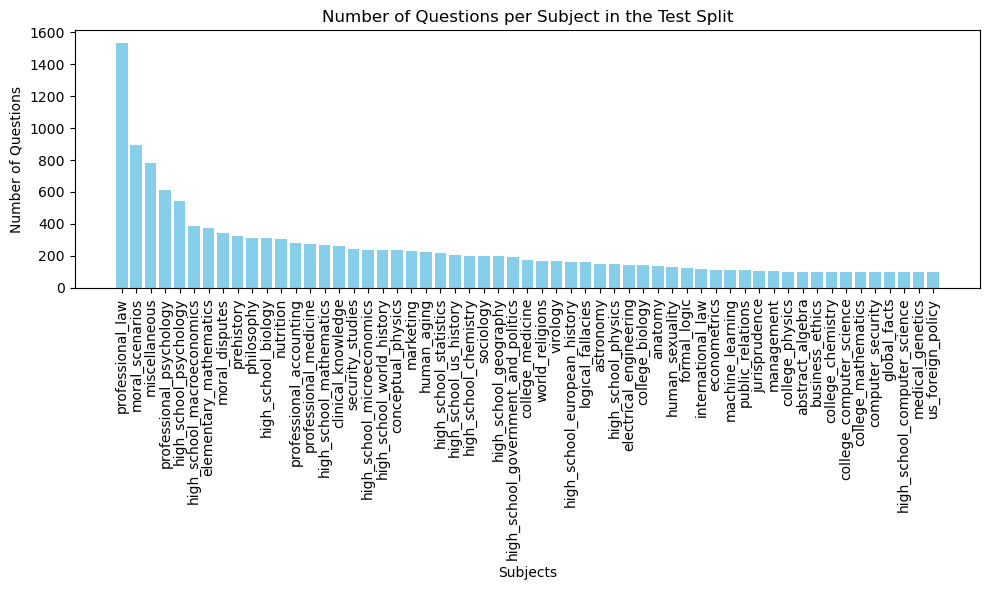

In [9]:
import matplotlib.pyplot as plt

# Sort the subjects by the number of questions in descending order
sorted_subject_counts = dict(sorted(subject_counts.items(), key=lambda item: item[1], reverse=True))

# Plotting the bar graph
subjects = list(sorted_subject_counts.keys())
counts = list(sorted_subject_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(subjects, counts, color='skyblue')
plt.xlabel('Subjects')
plt.ylabel('Number of Questions')
plt.title('Number of Questions per Subject in the Test Split')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [10]:
# Collect unique answers
unique_answers = list(set(sample['answer'] for sample in test_split))

# Print the unique answers
print("Possible answers in the test split:")
print(unique_answers)
print(type(unique_answers[0]))

Possible answers in the test split:
[0, 1, 2, 3]
<class 'int'>


In [11]:
# Retrieve a sample question and answer
sample = test_split[0]  # Get the first sample

# Print the sample question and answer
print("Question:", sample['question'])
print("Subject:", sample['subject'])
print("Choices:", sample['choices'])
print("Answer:", sample['answer'])

Question: Find the degree for the given field extension Q(sqrt(2), sqrt(3), sqrt(18)) over Q.
Subject: abstract_algebra
Choices: ['0', '4', '2', '6']
Answer: 1


Prompt Formatting

In [12]:
def format_example(example, include_answer=True): 
    '''
    Input Example:
    {
        "question": "Find the degree for the given field extension Q(sqrt(2), sqrt(3), sqrt(18)) over Q.",
        "choices": ["0", "4", "2", "6"],
        "answer": 1
    }

    '''
    prompt = ""
    prompt += "<|start_header_id|>user<|end_header_id|>\n\nGiven the following question and four candidate answers (A, B, C and D), choose the best answer.\n"
    prompt += f"Question: {example['question'].lstrip()}\n"

    # Iterate over the choices and append each choice to the prompt
    for i, choice in enumerate(example['choices']):
        prompt += f"{chr(65 + i)}. {choice}\n"  # Use chr(65 + i) to get 'A', 'B', 'C', etc.
    
    prompt += 'Your response should end with "The best answer is [the_answer_letter]" where the [the_answer_letter] is one of A, B, C or D.<|eot_id|>'
    
    # If include_answer is True, append the correct answer to the prompt
    if include_answer:    
        answer_letter = chr(65 + int(example['answer']))  # Convert numerical answer to alphabetical
        prompt += f"<|start_header_id|>assistant<|end_header_id|>\n\nThe best answer is {answer_letter}.<|eot_id|>"
    else:
        prompt += "<|start_header_id|>assistant<|end_header_id|>\n\nThe best answer is"
    
    # Return the formatted prompt
    return prompt

# Format the sample example
formatted_sample = format_example(sample)
print(formatted_sample)

<|start_header_id|>user<|end_header_id|>

Given the following question and four candidate answers (A, B, C and D), choose the best answer.
Question: Find the degree for the given field extension Q(sqrt(2), sqrt(3), sqrt(18)) over Q.
A. 0
B. 4
C. 2
D. 6
Your response should end with "The best answer is [the_answer_letter]" where the [the_answer_letter] is one of A, B, C or D.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The best answer is B.<|eot_id|>


In [14]:
def gen_prompt(train_data, subject, k=-1, initialize=True):
    '''
    Input Example:
    train_data = [
        {
            "question": "Find the degree for the given field extension Q(sqrt(2), sqrt(3), sqrt(18)) over Q.",
            "choices": ["0", "4", "2", "6"],
            "answer": 1
        },
        {
            "question": "Let p = (1, 2, 5, 4)(2, 3) in S_5 . Find the index of <p> in S_5.",
            "choices": ["8", "2", "24", "120"],
            "answer": 2
        }
    ]
    '''
    # Initialize the prompt with an introductory sentence about the subject
    prompt = ""
    if initialize:
        prompt = f"The following are multiple choice questions (with the best answers) about {subject.replace('_', ' ')}.\n\n"
        #prompt = "Given the following question and four candidate answers (A, B, C and D), choose the best answer.\n\n"
    
    # Determine the number of examples to include in the prompt
    # If k is -1, include all examples from train_data; otherwise, include the first k examples
    num_examples = len(train_data) if k == -1 else k
    
    # Iterate over the specified number of examples
    for i in range(num_examples):
        # Format each example and append it to the prompt
        prompt += format_example(train_data[i])
    
    # Return the generated prompt
    return prompt

# Generate a 5-shot training prompt using the sample data
sample_prompt_train = gen_prompt(train_split, "mathematics", k=5, initialize=False)

# Generate a prompt without label using the sample data
sample_unknown = test_split[0]
sample_prompt_end = format_example(sample_unknown, include_answer=False)
sample_label = chr(65 + int(sample_unknown['answer'])) # Convert numerical answer to alphabetical

# Combine the training prompt with the last example from the test split
sample_prompt = sample_prompt_train + sample_prompt_end
print(sample_prompt)
print(f'Label: {sample_label}')

<|start_header_id|>user<|end_header_id|>

Given the following question and four candidate answers (A, B, C and D), choose the best answer.
Question: Find all c in Z_3 such that Z_3[x]/(x^2 + c) is a field.
A. 0
B. 1
C. 2
D. 3
Your response should end with "The best answer is [the_answer_letter]" where the [the_answer_letter] is one of A, B, C or D.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The best answer is B.<|eot_id|><|start_header_id|>user<|end_header_id|>

Given the following question and four candidate answers (A, B, C and D), choose the best answer.
Question: Statement 1 | If aH is an element of a factor group, then |aH| divides |a|. Statement 2 | If H and K are subgroups of G then HK is a subgroup of G.
A. True, True
B. False, False
C. True, False
D. False, True
Your response should end with "The best answer is [the_answer_letter]" where the [the_answer_letter] is one of A, B, C or D.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The best answer is B.<|e

Test model with sample prompt

In [15]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Custom dataset for prompts
class PromptDataset(Dataset):
    def __init__(self, prompts):
        self.prompts = prompts

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        return self.prompts[idx]


In [16]:
def truncate_prompt(prompt, max_prompt_len):
    # Tokenize the prompt
    tokens = tokenizer.tokenize(prompt)
    
    # Check if the prompt length exceeds the maximum length
    while len(tokens) + 1 > max_prompt_len:
        # Split the prompt into sections based on the <|eot_id|> delimiter
        sections = prompt.split('<|eot_id|>')
        
        # Ensure there are enough sections to remove
        if len(sections) > 2:
            # Remove the first 5-shot example (first two sections)
            prompt = '<|eot_id|>'.join(sections[2:])
        else:
            # If there are not enough sections, break the loop
            break
        
        # Re-tokenize the updated prompt
        tokens = tokenizer.tokenize(prompt)
    
    return prompt

# Example usage
prompt = sample_prompt
prompt_len = max_prompt_len  # Example maximum length
prompt = truncate_prompt(prompt, prompt_len)
print(prompt)

<|start_header_id|>user<|end_header_id|>

Given the following question and four candidate answers (A, B, C and D), choose the best answer.
Question: Find all c in Z_3 such that Z_3[x]/(x^2 + c) is a field.
A. 0
B. 1
C. 2
D. 3
Your response should end with "The best answer is [the_answer_letter]" where the [the_answer_letter] is one of A, B, C or D.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The best answer is B.<|eot_id|><|start_header_id|>user<|end_header_id|>

Given the following question and four candidate answers (A, B, C and D), choose the best answer.
Question: Statement 1 | If aH is an element of a factor group, then |aH| divides |a|. Statement 2 | If H and K are subgroups of G then HK is a subgroup of G.
A. True, True
B. False, False
C. True, False
D. False, True
Your response should end with "The best answer is [the_answer_letter]" where the [the_answer_letter] is one of A, B, C or D.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The best answer is B.<|e

In [17]:
# Create a sample record
sample_record = {'prompt': sample_prompt,
                 'answer': sample_label}

In [18]:
import re

def batch_infer(prompts, batch_size=8, show_output=False, k=5):
    '''
    Example:
    prompts = [
        "What is the capital of France?",
        "What is the capital of Germany?"
    ]

    Output:
    ["Paris", "Berlin"]
    '''
    
    # Create the custom dataset
    prompt_dataset = PromptDataset(prompts)
    
    # Create DataLoader with the specified batch size
    dataloader = DataLoader(prompt_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize an empty list to store the final answers
    answers = []
    
    # Iterate over each batch of prompts from the DataLoader
    for batch_prompts in tqdm(dataloader):
        # Generate the output from the model using the pipeline
        outputs = pipe(batch_prompts, 
                       do_sample=False, 
                       top_k=top_k,
                       top_p=top_p,
                       temperature=temperature,
                       max_new_tokens=10,
                       num_return_sequences=num_generations)
        
        for output in outputs:
            # Extract the generated text
            generated_text = output[0]['generated_text']

            # Extract the letter after the last occurrence of "The best answer is"
            matches = re.findall(r'The best answer is ([A-D])', generated_text)
            num = (generated_text.count('<|eot_id|>') - 1) / 2
            
            if len(matches) == num + 1:
                answer = matches[-1]  # Get the last match
            else:
                answer = 'E'  # Default to 'E' if no valid answer is found
            
            if show_output:
                print(generated_text)
                print(f"Extracted answer: {answer}")
            
            answers.append(answer)
    
    # Return the final list of answers
    return answers


In [19]:
# Generate the answer
batch_infer([sample_record['prompt']], batch_size=1, show_output=True)

  0%|          | 0/1 [00:00<?, ?it/s]/data/students/mary/anaconda3/envs/dl_course/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/data/students/mary/anaconda3/envs/dl_course/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/data/students/mary/anaconda3/envs/dl_course/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:589: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True

<|start_header_id|>user<|end_header_id|>

Given the following question and four candidate answers (A, B, C and D), choose the best answer.
Question: Find all c in Z_3 such that Z_3[x]/(x^2 + c) is a field.
A. 0
B. 1
C. 2
D. 3
Your response should end with "The best answer is [the_answer_letter]" where the [the_answer_letter] is one of A, B, C or D.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The best answer is B.<|eot_id|><|start_header_id|>user<|end_header_id|>

Given the following question and four candidate answers (A, B, C and D), choose the best answer.
Question: Statement 1 | If aH is an element of a factor group, then |aH| divides |a|. Statement 2 | If H and K are subgroups of G then HK is a subgroup of G.
A. True, True
B. False, False
C. True, False
D. False, True
Your response should end with "The best answer is [the_answer_letter]" where the [the_answer_letter] is one of A, B, C or D.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The best answer is B.<|e

['B']

Model Evaluation with Dataset

In [20]:
import time
import json

run_results = {}

# Define the output filename based on the model type and parameter size
output_filename = f'run_results_llama32_1b_final.json'

subjects_list_sample = ['elementary_mathematics', 
                        'high_school_mathematics', 'high_school_physics',
                        'college_mathematics', 'college_physics', 'college_computer_science', 'college_chemistry',
                        'formal_logic', 'moral_scenarios', 'global_facts',
                        'abstract_algebra', 'machine_learning']

subjects_list = subjects_list_all
# subjects_list = subjects_list_sample

# Measure the start time
start_time = time.time()

for task in subjects_list:
    print(f'Testing {task}...')
    records = []  # Initialize an empty list to store the records for the current task

    # Filter the dev and test set of the dataset to include only the current task
    train_data = train_split.filter(lambda x: x['subject'] == task)
    train_data = list(train_data)  # Convert to list for indexing

    test_data = test_split.filter(lambda x: x['subject'] == task)
    test_data = list(test_data)  # Convert to list for indexing

    # Create records for the task
    for example in test_data:

        # Format the example without including the answer
        prompt_end = format_example(example, include_answer=False)

        # For now, we're assuming a fixed 5-shot setting for training data
        # Generate a training prompt using a fixed 5-shot setting
        train_prompt = gen_prompt(train_data, task, k=5, initialize=True)

        # Combine the training prompt and the formatted example
        prompt = train_prompt + prompt_end
        
        # Ensure the prompt length does not exceed the maximum token length
        prompt = truncate_prompt(prompt, max_prompt_len)
                
        # Get the correct answer for the example
        answer_index = int(example['answer'])
        label = chr(65 + answer_index) # Convert numerical answer to alphabetical

        records.append({'prompt': prompt, 'answer': label})

    # Perform batch inference on the records
    pred_answers = batch_infer([record['prompt'] for record in records])

    # Print the time taken for inference
    corr_answers = [record['answer'] for record in records]
    run_results[task] = {'pred_answers': pred_answers, 'corr_answers': corr_answers}

    torch.cuda.empty_cache()

# Measure the end time
end_time = time.time()

# Calculate the evaluation time
evaluation_time = end_time - start_time
print(f"Total evaluation time: {evaluation_time:.2f} seconds")

with open(output_filename, 'w') as f:
    json.dump(run_results, f, ensure_ascii=False, indent=2)

Testing elementary_mathematics...


  0%|          | 0/48 [00:00<?, ?it/s]/data/students/mary/anaconda3/envs/dl_course/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/data/students/mary/anaconda3/envs/dl_course/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/data/students/mary/anaconda3/envs/dl_course/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:589: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=Tru

Testing world_religions...


100%|██████████| 22/22 [00:08<00:00,  2.66it/s]


Testing business_ethics...


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Testing marketing...


100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Testing high_school_world_history...


100%|██████████| 30/30 [00:17<00:00,  1.67it/s]


Testing professional_accounting...


100%|██████████| 36/36 [00:16<00:00,  2.23it/s]


Testing anatomy...


100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


Testing high_school_european_history...


100%|██████████| 21/21 [00:17<00:00,  1.19it/s]


Testing college_mathematics...


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


Testing clinical_knowledge...


100%|██████████| 34/34 [00:13<00:00,  2.44it/s]


Testing miscellaneous...


100%|██████████| 98/98 [00:38<00:00,  2.54it/s]


Testing high_school_government_and_politics...


100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


Testing high_school_computer_science...


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


Testing public_relations...


100%|██████████| 14/14 [00:05<00:00,  2.41it/s]


Testing formal_logic...


100%|██████████| 16/16 [00:07<00:00,  2.28it/s]


Testing computer_security...


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Testing professional_psychology...


100%|██████████| 77/77 [00:34<00:00,  2.26it/s]


Testing moral_scenarios...


100%|██████████| 112/112 [00:51<00:00,  2.19it/s]


Testing global_facts...


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


Testing high_school_us_history...


100%|██████████| 26/26 [00:19<00:00,  1.35it/s]


Testing us_foreign_policy...


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


Testing high_school_physics...


100%|██████████| 19/19 [00:08<00:00,  2.27it/s]


Testing nutrition...


100%|██████████| 39/39 [00:17<00:00,  2.28it/s]


Testing conceptual_physics...


100%|██████████| 30/30 [00:11<00:00,  2.60it/s]


Testing college_biology...


100%|██████████| 18/18 [00:07<00:00,  2.30it/s]


Testing college_physics...


100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


Testing astronomy...


100%|██████████| 19/19 [00:08<00:00,  2.26it/s]


Testing international_law...


100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Testing high_school_geography...


100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Testing logical_fallacies...


100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Testing professional_medicine...


100%|██████████| 34/34 [00:17<00:00,  1.90it/s]


Testing high_school_macroeconomics...


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Testing human_aging...


100%|██████████| 28/28 [00:10<00:00,  2.57it/s]


Testing electrical_engineering...


100%|██████████| 19/19 [00:07<00:00,  2.48it/s]


Testing jurisprudence...


100%|██████████| 14/14 [00:05<00:00,  2.42it/s]


Testing medical_genetics...


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


Testing high_school_psychology...


100%|██████████| 69/69 [00:29<00:00,  2.31it/s]


Testing high_school_biology...


100%|██████████| 39/39 [00:16<00:00,  2.31it/s]


Testing econometrics...


100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


Testing prehistory...


100%|██████████| 41/41 [00:17<00:00,  2.29it/s]


Testing virology...


100%|██████████| 21/21 [00:08<00:00,  2.56it/s]


Testing abstract_algebra...


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


Testing college_chemistry...


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Testing management...


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


Testing moral_disputes...


100%|██████████| 44/44 [00:18<00:00,  2.35it/s]


Testing machine_learning...


100%|██████████| 14/14 [00:06<00:00,  2.19it/s]


Testing high_school_microeconomics...


100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


Testing college_medicine...


100%|██████████| 22/22 [00:09<00:00,  2.31it/s]


Testing human_sexuality...


100%|██████████| 17/17 [00:06<00:00,  2.63it/s]


Testing high_school_chemistry...


100%|██████████| 26/26 [00:11<00:00,  2.32it/s]


Testing high_school_mathematics...


100%|██████████| 34/34 [00:14<00:00,  2.31it/s]


Testing sociology...


100%|██████████| 26/26 [00:11<00:00,  2.36it/s]


Testing professional_law...


100%|██████████| 192/192 [02:03<00:00,  1.55it/s]


Testing college_computer_science...


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]


Testing high_school_statistics...


100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Testing philosophy...


100%|██████████| 39/39 [00:15<00:00,  2.55it/s]


Testing security_studies...


100%|██████████| 31/31 [00:16<00:00,  1.84it/s]

Total evaluation time: 863.18 seconds


Compute Macro Average Accuracies

In [21]:
subcategories = {
    "abstract_algebra": ["math"],
    "anatomy": ["health"],
    "astronomy": ["physics"],
    "business_ethics": ["business"],
    "clinical_knowledge": ["health"],
    "college_biology": ["biology"],
    "college_chemistry": ["chemistry"],
    "college_computer_science": ["computer science"],
    "college_mathematics": ["math"],
    "college_medicine": ["health"],
    "college_physics": ["physics"],
    "computer_security": ["computer science"],
    "conceptual_physics": ["physics"],
    "econometrics": ["economics"],
    "electrical_engineering": ["engineering"],
    "elementary_mathematics": ["math"],
    "formal_logic": ["philosophy"],
    "global_facts": ["other"],
    "high_school_biology": ["biology"],
    "high_school_chemistry": ["chemistry"],
    "high_school_computer_science": ["computer science"],
    "high_school_european_history": ["history"],
    "high_school_geography": ["geography"],
    "high_school_government_and_politics": ["politics"],
    "high_school_macroeconomics": ["economics"],
    "high_school_mathematics": ["math"],
    "high_school_microeconomics": ["economics"],
    "high_school_physics": ["physics"],
    "high_school_psychology": ["psychology"],
    "high_school_statistics": ["math"],
    "high_school_us_history": ["history"],
    "high_school_world_history": ["history"],
    "human_aging": ["health"],
    "human_sexuality": ["culture"],
    "international_law": ["law"],
    "jurisprudence": ["law"],
    "logical_fallacies": ["philosophy"],
    "machine_learning": ["computer science"],
    "management": ["business"],
    "marketing": ["business"],
    "medical_genetics": ["health"],
    "miscellaneous": ["other"],
    "moral_disputes": ["philosophy"],
    "moral_scenarios": ["philosophy"],
    "nutrition": ["health"],
    "philosophy": ["philosophy"],
    "prehistory": ["history"],
    "professional_accounting": ["other"],
    "professional_law": ["law"],
    "professional_medicine": ["health"],
    "professional_psychology": ["psychology"],
    "public_relations": ["politics"],
    "security_studies": ["politics"],
    "sociology": ["culture"],
    "us_foreign_policy": ["politics"],
    "virology": ["health"],
    "world_religions": ["philosophy"],
}

cat_to_sub = {
    "STEM": ["physics", "chemistry", "biology", "computer science", "math", "engineering"],
    "humanities": ["history", "philosophy", "law"],
    "social sciences": ["politics", "culture", "economics", "geography", "psychology"],
    "others": ["other", "business", "health"],
}

sub_to_cat = {
    'physics': 'STEM', 
    'chemistry': 'STEM', 
    'biology': 'STEM', 
    'computer science': 'STEM', 
    'math': 'STEM', 
    'engineering': 'STEM', 
    'history': 'humanities', 
    'philosophy': 'humanities', 
    'law': 'humanities', 
    'politics': 'social sciences', 
    'culture': 'social sciences', 
    'economics': 'social sciences', 
    'geography': 'social sciences', 
    'psychology': 'social sciences', 
    'other': 'others', 
    'business': 'others', 
    'health': 'others'
 }

In [22]:
!pip install seaborn

Macro-Average Accuracy: 49.2

Task Accuracies:
elementary_mathematics: 33.3
world_religions: 67.8
business_ethics: 47.0
marketing: 72.2
high_school_world_history: 62.0
professional_accounting: 36.5
anatomy: 54.8
high_school_european_history: 58.8
college_mathematics: 35.0
clinical_knowledge: 52.1
miscellaneous: 65.1
high_school_government_and_politics: 59.6
high_school_computer_science: 46.0
public_relations: 47.3
formal_logic: 33.3
computer_security: 56.0
professional_psychology: 43.0
moral_scenarios: 28.3
global_facts: 32.0
high_school_us_history: 57.8
us_foreign_policy: 69.0
high_school_physics: 31.1
nutrition: 58.8
conceptual_physics: 44.7
college_biology: 54.2
college_physics: 27.5
astronomy: 56.6
international_law: 63.6
high_school_geography: 61.6
logical_fallacies: 50.3
professional_medicine: 55.5
high_school_macroeconomics: 43.1
human_aging: 52.9
electrical_engineering: 55.2
jurisprudence: 59.3
medical_genetics: 56.0
high_school_psychology: 67.3
high_school_biology: 56.1
econom

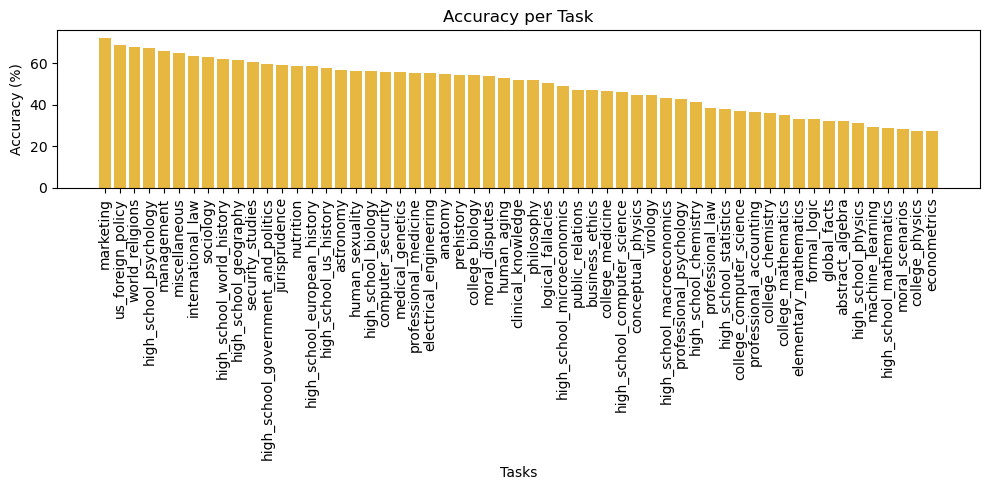

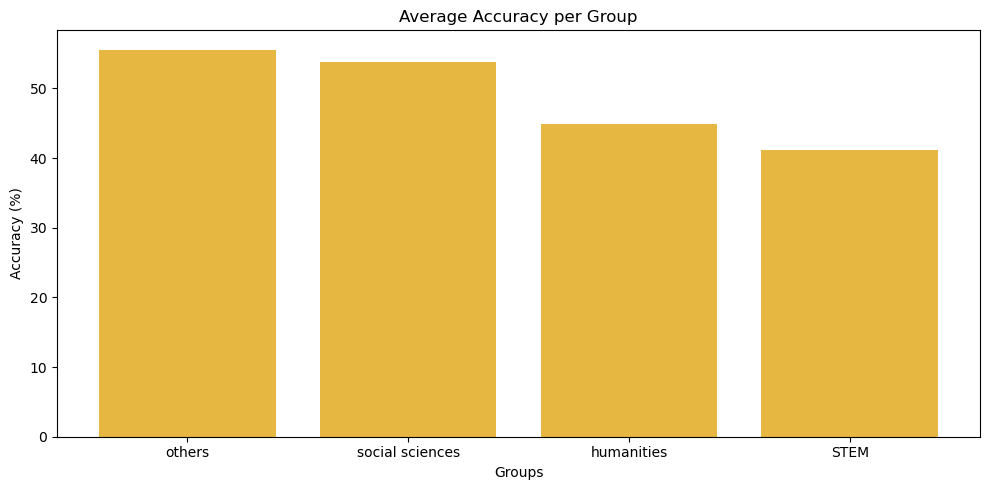

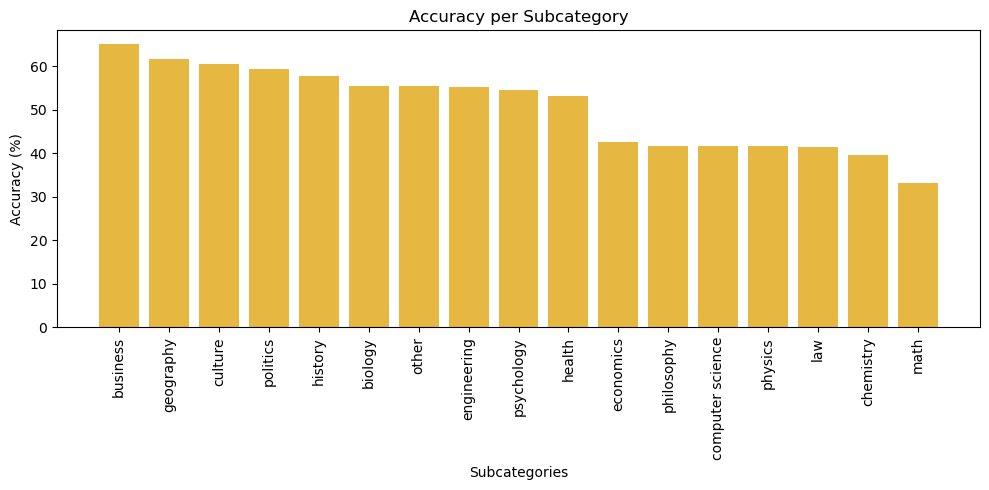

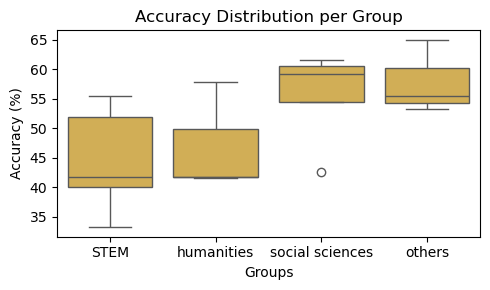

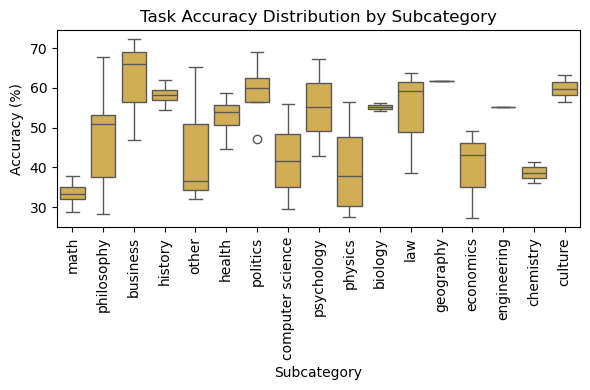

In [23]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def subject_analysis(output_filename, subcategories, sub_to_cat):
    # Load data
    with open(output_filename, 'r') as f:
        run_results = json.load(f)

    # Initialize counters for accuracy tracking
    subcategory_acc = {sub: {'correct': 0, 'total': 0} for sub in sub_to_cat.keys()}
    category_acc = {cat: {'correct': 0, 'total': 0} for cat in sub_to_cat.values()}
    task_acc = {}

    task_accuracies = []
    
    # Process task results
    for task, results in run_results.items():
        pred_answers, corr_answers = results['pred_answers'], results['corr_answers']
        acc = sum(p == c for p, c in zip(pred_answers, corr_answers))
        task_accuracy = acc / len(corr_answers)
        
        task_acc[task] = task_accuracy
        task_accuracies.append(task_accuracy)

        # Update subcategory and category accuracies
        subcategory = subcategories[task][0]
        category = sub_to_cat[subcategory]
        
        update_accuracy(subcategory_acc, subcategory, acc, len(corr_answers))
        update_accuracy(category_acc, category, acc, len(corr_answers))

    # Print accuracies
    print_accuracies(task_acc, subcategory_acc, category_acc, task_accuracies)

    # Plot charts
    plot_bar_chart(task_acc, 'Tasks', 'Accuracy per Task')
    plot_bar_chart({cat: acc['correct'] / acc['total'] for cat, acc in category_acc.items() if acc['total'] > 0}, 'Groups', 'Average Accuracy per Group')
    plot_bar_chart({sub: acc['correct'] / acc['total'] for sub, acc in subcategory_acc.items() if acc['total'] > 0}, 'Subcategories', 'Accuracy per Subcategory')
    plot_box_plot(subcategory_acc, sub_to_cat)  # Existing box plot for categories
    plot_subcategory_box_plot(task_acc, subcategories)  # New box plot for subcategories

def update_accuracy(acc_dict, key, correct, total):
    acc_dict[key]['correct'] += correct
    acc_dict[key]['total'] += total

def print_accuracies(task_acc, subcategory_acc, category_acc, task_accuracies):
    # Macro-Average accuracy
    macro_avg = sum(task_accuracies) / len(task_accuracies) * 100
    print(f"Macro-Average Accuracy: {macro_avg:.1f}\n")

    print("Task Accuracies:")
    # Task-level accuracy
    for task, acc in task_acc.items():
        print(f"{task}: {acc * 100:.1f}")
    
    # Subcategory and category accuracies
    print("\nSubcategory Accuracies:")
    for sub, acc in subcategory_acc.items():
        if acc['total'] > 0:
            print(f"{sub}: {acc['correct'] / acc['total'] * 100:.1f}")

    print("\nCategory Accuracies:")
    for cat, acc in category_acc.items():
        if acc['total'] > 0:
            print(f"{cat}: {acc['correct'] / acc['total'] * 100:.1f}")

def plot_bar_chart(data, xlabel, title):
    sorted_data = sorted(data.items(), key=lambda item: item[1], reverse=True)
    labels, values = zip(*sorted_data)

    plt.figure(figsize=(10, 5))
    plt.bar(labels, [v * 100 for v in values], color='#e6b741')  # Updated color
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy (%)')
    plt.title(title)
    plt.xticks(rotation=90 if xlabel != 'Groups' else 0)
    plt.tight_layout()
    plt.show()

def plot_box_plot(subcategory_acc, sub_to_cat):
    data = [{'Group': sub_to_cat[sub], 'Accuracy': acc['correct'] / acc['total'] * 100}
            for sub, acc in subcategory_acc.items() if acc['total'] > 0]

    df = pd.DataFrame(data)

    plt.figure(figsize=(5, 3))
    sns.boxplot(x='Group', y='Accuracy', data=df, color='#e6b741')  # Updated color
    plt.xlabel('Groups')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Distribution per Group')
    plt.tight_layout()
    plt.show()

def plot_subcategory_box_plot(task_acc, subcategories):
    """
    Plot a box plot of task accuracies grouped by their corresponding subcategories.
    """
    # Prepare the data for the box plot
    data = [{'Subcategory': subcategories[task][0], 'Accuracy': acc * 100}
            for task, acc in task_acc.items()]

    df = pd.DataFrame(data)

    # Create the box plot
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Subcategory', y='Accuracy', data=df, color='#e6b741')  # Updated color
    plt.xlabel('Subcategory')
    plt.ylabel('Accuracy (%)')
    plt.title('Task Accuracy Distribution by Subcategory')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Example usage
output_filename = 'run_results_llama32_1b_final.json'
subject_analysis(output_filename, subcategories, sub_to_cat)
